In [ ]:
import nltk
from nltk.corpus import gutenberg
from nltk.corpus import stopwords
import string
import random
import requests
import pandas as pd
import re
import numpy as np

In [ ]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

change to lower and remove non-alphabetic character and stopwords

In [ ]:
def clear_text(text):

    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    cleaned_words = [word for word in words if word not in stop_words]

    return ' '.join(cleaned_words)

function for getting random word samples from  each book

In [ ]:
def get_gutenberg_book(url):
    response = requests.get(url)
    return response.text

In [ ]:
def create_samples(book, label, num_samples=200, words_per_sample=100):
    book_text = get_gutenberg_book(book_url)
    clean_text = clear_text(book_text)
    words = nltk.word_tokenize(clean_text)
    partitions = [words[i:i + words_per_sample] for i in range(0, len(words), words_per_sample)]
    num_partitions = min(num_samples, len(partitions))
    random_partitions = random.sample(partitions, num_partitions)
    samples = [{'text': ' '.join(partition), 'label': label} for partition in random_partitions]
    return samples

Book list

In [ ]:
book_urls = [
    ('https://www.gutenberg.org/files/158/158-0.txt', 'Austen'),
    ('https://www.gutenberg.org/files/768/768-0.txt', 'Bronte'),
    ('https://www.gutenberg.org/files/1260/1260-0.txt', 'Bronte'),
    ('https://www.gutenberg.org/files/1400/1400-0.txt', 'Dickens'),
    ('https://www.gutenberg.org/files/145/145-0.txt', 'Eliot'),
    ('https://www.gutenberg.org/cache/epub/541/pg541.txt', 'Wharton')
]

all_samples = []
for book_url, label in book_urls:
    samples = create_samples(book_url, label)
    all_samples.extend(samples)

df = pd.DataFrame(all_samples)
df.head()

,text,label
0,love harriet still can not refuse invitation m...,Austen
1,every thing relapsing much usual state former ...,Austen
2,disadvantages threatened alloy many enjoyments...,Austen
3,good humour recommend mind true gentility harr...,Austen
4,hope could sort affection question hope times ...,Austen


In [ ]:
#from google.colab import files
df.to_csv('final.csv', index=False)
#files.download('final.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

glove_file_path= '/content/gdrive/My Drive/Colab Notebooks/glove.6B/glove.6B.50d.txt'

# Function to load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings into the dictionary
glove_embeddings = load_glove_embeddings(glove_file_path)

Mounted at /content/gdrive


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
model = [
    OneVsRestClassifier(SVC(kernel="linear")),
    OneVsRestClassifier(SVC(kernel="rbf")),
    OneVsRestClassifier(SVC(kernel="poly")),
    RandomForestClassifier(),
    GaussianNB(),
    KNeighborsClassifier(),
    OneVsOneClassifier(SGDClassifier()),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(random_state=69)
    ]


names = [
    "Linear SVC",
    "Gaussian SVC",
    "Polynomial SVC",
    "RandomForestClassifier",
    "Naive Bayes",
    "KNeighborsClassifier",
    "SGDClassifier",
    "DecisionTreeClassifier",
    "AdaBoostClassifier",
    "XGBClassifier",
]


MODEL: Linear SVC
Average Accuracy: 0.9
Average Precision: 0.8939750534248351
Average Recall: 0.8863498140607746
Average F1: 0.8878135321281425
Average ROC AUC: 0.8939750534248352
MODEL: Gaussian SVC
Average Accuracy: 0.8916666666666666
Average Precision: 0.8808074725285484
Average Recall: 0.8779761315975408
Average F1: 0.8778503911324342
Average ROC AUC: 0.8808074725285484
MODEL: Polynomial SVC
Average Accuracy: 0.8983333333333332
Average Precision: 0.8854999652315346
Average Recall: 0.8871426181840751
Average F1: 0.8849542315780174
Average ROC AUC: 0.8854999652315346
MODEL: RandomForestClassifier
Average Accuracy: 0.8766666666666666
Average Precision: 0.853066543704901
Average Recall: 0.8672488419508753
Average F1: 0.8584052164295457
Average ROC AUC: 0.853066543704901
MODEL: Naive Bayes
Average Accuracy: 0.85
Average Precision: 0.8613672972593998
Average Recall: 0.8345993336133104
Average F1: 0.8390376257650516
Average ROC AUC: 0.8613672972593998
MODEL: KNeighborsClassifier
Average A

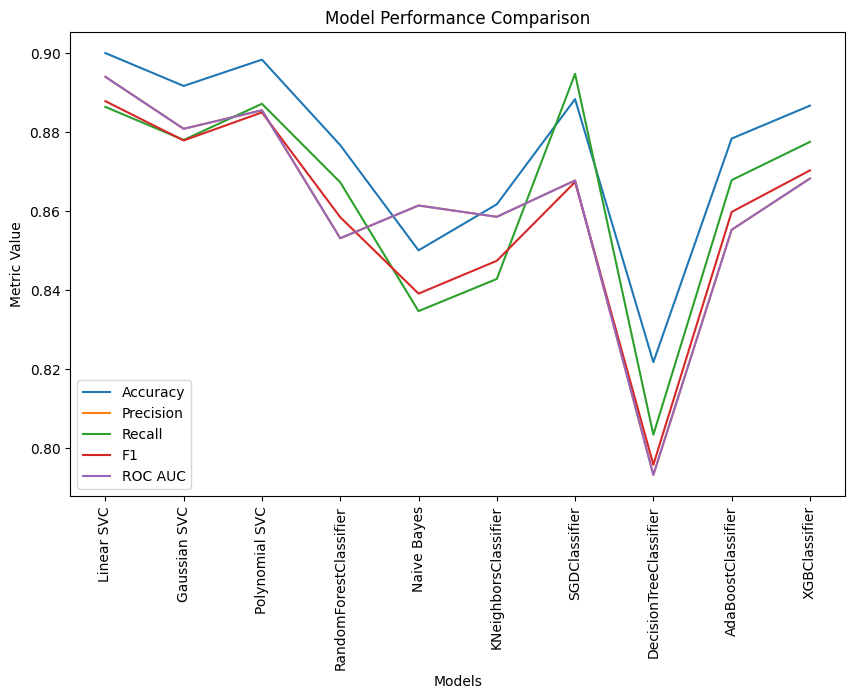

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Assuming you have defined 'model' and 'names' somewhere in your code

kf = KFold(n_splits=10, shuffle=True, random_state=69)
onehot_encoder = OneHotEncoder(sparse=False, drop='first')

# Lists to store metric values for each model
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

for m_obj, m_name in zip(model, names):
    acc_sum = 0
    precision_sum = 0
    recall_sum = 0
    f1_sum = 0
    roc_auc_sum = 0

    for train_index, test_index in kf.split(df[:600]):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]
        X_train = train_data['text']
        y_train = train_data['label']
        X_test = test_data['text']
        y_test = train_data['label']

        # Create document embeddings using GloVe
        X_train_glove = np.array([np.mean([glove_embeddings.get(word, np.zeros(50)) for word in sentence.split()], axis=0) for sentence in X_train])
        X_test_glove = np.array([np.mean([glove_embeddings.get(word, np.zeros(50)) for word in sentence.split()], axis=0) for sentence in X_test])

        # One-hot encoding for the label
        y_train_onehot = onehot_encoder.fit_transform(train_data[['label']])
        y_test_onehot = onehot_encoder.transform(test_data[['label']])
        y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['label']))
        y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['label']))

        #Model Training and Prediction
        m_obj.fit(X_train_glove, y_train_df)
        y_pred = m_obj.predict(X_test_glove)

        # Compute Evaluation Metrics
        acc = accuracy_score(y_pred, y_test_df)
        precision = precision_score(y_pred, y_test_df, average='macro')
        recall = recall_score(y_pred, y_test_df, average='macro')
        f1 = f1_score(y_pred, y_test_df, average='macro')
        roc_auc = roc_auc_score(y_test_df, y_pred, average='macro')

        acc_sum += acc
        precision_sum += precision
        recall_sum += recall
        f1_sum += f1
        roc_auc_sum += roc_auc

    # Calculate average metric values for the model
    avg_acc = acc_sum / 10
    avg_precision = precision_sum / 10
    avg_recall = recall_sum / 10
    avg_f1 = f1_sum / 10
    avg_roc_auc = roc_auc_sum / 10

    # Append the average metric values to the respective lists
    accuracy_list.append(avg_acc)
    precision_list.append(avg_precision)
    recall_list.append(avg_recall)
    f1_list.append(avg_f1)
    roc_auc_list.append(avg_roc_auc)

    print("MODEL: {}".format(m_name))
    print("Average Accuracy: {}".format(avg_acc))
    print("Average Precision: {}".format(avg_precision))
    print("Average Recall: {}".format(avg_recall))
    print("Average F1: {}".format(avg_f1))
    print("Average ROC AUC: {}".format(avg_roc_auc))
    print("==========================================")

# Plotting the graph
models_names = names
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.3)

for i, metric_list in enumerate([accuracy_list, precision_list, recall_list, f1_list, roc_auc_list]):
    plt.plot(models_names, metric_list, label=metrics[i])


plt.title('Model Performance Comparison')
plt.xlabel('Models')

# Rotate model names vertically
plt.xticks(rotation=90, ha='center')

plt.ylabel('Metric Value')
plt.legend()
plt.show()